In [2]:
# Import all modules
%matplotlib inline
import time
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import pickle
import matplotlib.colors as mcolors
from PIL import Image
import scipy
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import h5py
import torch.utils.data
# Import Tensorflow with multiprocessing
import multiprocessing as mp


/home/joonsikk/anaconda3/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def load_AwA():
    train_input = np.squeeze(np.load('../data/train_input.npy'))
    train_label = np.squeeze(np.load('../data/train_label.npy'))
    val_input = np.squeeze(np.load('../data/val_input.npy'))
    val_label = np.squeeze(np.load('../data/val_label.npy'))
    train_feature = np.squeeze(np.load('../data/train_feature_awa.npy'))
    train_output = np.squeeze(np.load('../data/train_output_awa.npy'))
    val_feature = np.squeeze(np.load('../data/val_feature_awa.npy'))
    val_output = np.squeeze(np.load('../data/val_output_awa.npy'))
    return train_input,train_label,val_input,val_label,train_feature,train_output,val_feature,val_output

def resnet50_model(file):
    model = models.__dict__['resnet50'](pretrained = True)
    model.fc = torch.nn.Linear(2048,50)
    model = torch.nn.DataParallel(model).cuda()
    # optionally resume from a checkpoint
    print("=> loading checkpoint '{}'".format(file))
    checkpoint = torch.load(file)
    best_prec1 = checkpoint['best_prec1']
    model.load_state_dict(checkpoint['state_dict'])
    print("=> loaded checkpoint '{}' (epoch {})"
                  .format(file, checkpoint['epoch'])) 
    feature_model = nn.Sequential(*list(model.module.children())[:-1])
    feature_model = torch.nn.DataParallel(feature_model)
    feature_model = feature_model.cuda()
    return model,feature_model

# Declare variables
num_classes = 50 #    
target_class = 9

model,feature_model = resnet50_model('../data/checkpoint.pth.tar')
train_input,train_label,val_input,val_label,train_feature,train_output,val_feature,val_output = load_AwA() 
x_train = train_input
y_train = train_label
x_test = val_input
y_test = val_label
        
weight_matrix = np.load('../output/weight_matrix_AwA.npz')['weight_matrix']
    
train_output34 = train_feature
test_output34 = val_feature

class_names = dict()
class_names[0] = 'antelope' 
class_names[1] = 'bat'
class_names[2] = 'beaver'
class_names[3] = 'blue whale' 
class_names[4] = 'bobcat'
class_names[5] = 'buffalo' 
class_names[6] = 'chihuahua' 
class_names[7] = 'chimpanzee'
class_names[8] = 'collie' 
class_names[9] = 'cow'
class_names[10] = 'dalmation' 
class_names[11] = 'deer'
class_names[12] = 'dolphin'
class_names[13] = 'elephant' 
class_names[14] = 'fox'
class_names[15] = 'german shepherd' 
class_names[16] = 'giant panda' 
class_names[17] = 'giraffe'
class_names[18] = 'gorilla' 
class_names[19] = 'grizzly bear'
class_names[20] = 'hamster' 
class_names[21] = 'hippopotamus'
class_names[22] = 'horse'
class_names[23] = 'humpback whale' 
class_names[24] = 'killer whale'
class_names[25] = 'leopard' 
class_names[26] = 'lion' 
class_names[27] = 'mole'
class_names[28] = 'moose' 
class_names[29] = 'mouse'
class_names[30] = 'otter' 
class_names[31] = 'ox'
class_names[32] = 'persian cat'
class_names[33] = 'pig' 
class_names[34] = 'polar bear'
class_names[35] = 'rabbit' 
class_names[36] = 'raccoon' 
class_names[37] = 'rat'
class_names[38] = 'rhinoceros' 
class_names[39] = 'seal'
class_names[40] = 'sheep' 
class_names[41] = 'siamese cat'
class_names[42] = 'skunk'
class_names[43] = 'spider monkey' 
class_names[44] = 'squirrel'
class_names[45] = 'tiger' 
class_names[46] = 'walrus' 
class_names[47] = 'weasel'
class_names[48] = 'wolf' 
class_names[49] = 'zebra'

output_test_labels = np.argmax(val_output,axis=1)
output_train_labels = np.argmax(train_output,axis=1)

# Extra functions for visualization
def denormalize(image,mean = [0.485,0.456,0.406],std = [0.229,0.224,0.225]):
    return image*expand_dims_3(std) + expand_dims_3(mean)

def expand_dims_3(arr):
    return np.expand_dims(np.expand_dims(arr,0),0)

=> loading checkpoint '../data/checkpoint.pth.tar'
=> loaded checkpoint '../data/checkpoint.pth.tar' (epoch 90)


In [4]:
# sort the weight matrix for each target class
top_orders = dict()
for k in range(num_classes):
    idx = np.flip(np.argsort(weight_matrix[:,k]), axis=0)
    top_orders[k] = idx
    
top_abs_orders = dict()
for k in range(num_classes):
    idx = np.flip(np.argsort(np.abs(weight_matrix[:,k])), axis=0)
    top_abs_orders[k] = idx
    
# import influence values for the first 100 test points
inf = np.load('../output/awa_inf_test_1000.npz')['influences']

inf_pos_idx = np.flip(np.argsort(inf, axis=0), axis=0)
inf_neg_idx = np.argsort(inf, axis=0)
inf_abs_idx = np.flip(np.argsort(np.abs(inf), axis=0), axis=0)

# test idx that were used to compute influences
test_points = np.load('../output/idx_inf_awa_1000.npz')['idx']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


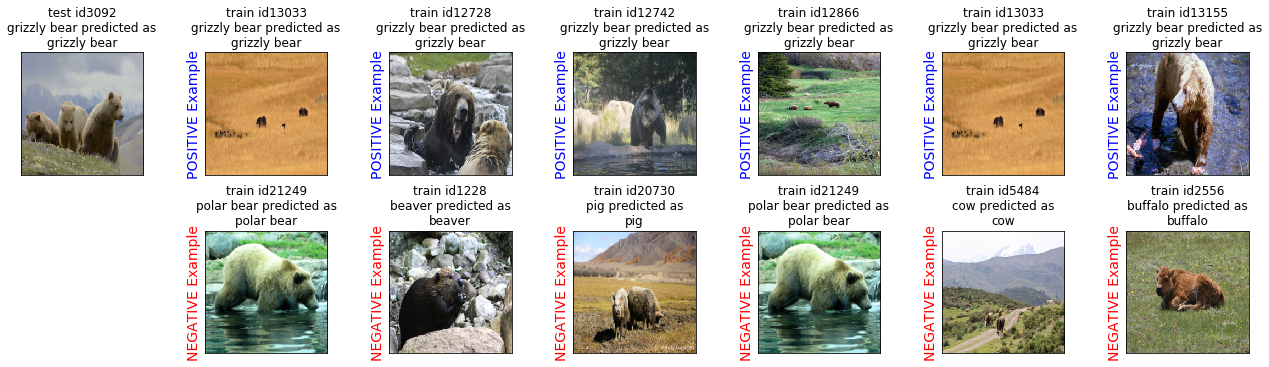

In [5]:
model.eval()
import matplotlib as mpl
import seaborn as sns

test_point = 3092    ## image of a grizzly bear
# test_point = 5727    ## image of a rhino

# need the test_point to be in test_points (since we are randomly selecting test points to compute the influence)
assert(test_point in test_points)
count = np.where(test_points == test_point)[0][0]

target_class = output_test_labels[test_point]
tmp = weight_matrix[:, target_class] * np.sum(train_feature * val_feature[test_point,:], axis=1)
pos_idx = np.flip(np.argsort(tmp), axis=0)
neg_idx = np.argsort(tmp)

# influence orders, a list of indices of the training points sorted based on the influence values

# the order for the paticular test point
inf_pos_order = inf_pos_idx[:, count]
inf_neg_order = inf_neg_idx[:, count]

# select top k from the alpha * train * test values
k = 3
f, ax = plt.subplots(2,7, figsize=(18, 18 / 7. * 2))

image = denormalize(x_test[test_point,:].transpose(1,2,0))
ax[0,0].imshow(image)
ax[0,0].set_title('test id%d\n%s predicted as\n%s'%(test_point, class_names[y_test[test_point]], class_names[output_test_labels[test_point]] ))
ax[0,0].set_xticks(())
ax[0,0].set_yticks(())

ax[1,0].get_xaxis().set_visible(False)
ax[1,0].set_yticks(())
ax[1,0].set_xticks(())
ax[1,0].axis('off')

# Representer values (first three columns)
for i in range(k):
    # Positive ones
    our_idx = pos_idx[i]
    ax[0, i+1].imshow(denormalize(x_train[our_idx].transpose(1,2,0)))
    ax[0, i+1].set_title('train id%d\n%s predicted as\n%s'%(our_idx, \
                                                            class_names[train_label[our_idx]],\
                                                            class_names[output_train_labels[our_idx]]))
    ax[0, i+1].set_ylabel('POSITIVE Example', fontsize=14)
    ax[0, i+1].yaxis.label.set_color('blue')
    ax[0, i+1].set_xticks(())
    ax[0, i+1].set_yticks(())

    # Negative ones
    our_idx = neg_idx[i]
    ax[1, i+1].imshow(denormalize(x_train[our_idx].transpose(1,2,0)))
    ax[1, i+1].set_title('train id%d\n%s predicted as\n%s'%(our_idx, \
                                                            class_names[train_label[our_idx]],\
                                                            class_names[output_train_labels[our_idx]]))
    ax[1, i+1].set_ylabel('NEGATIVE Example', fontsize=14)
    ax[1, i+1].yaxis.label.set_color('red')
    ax[1, i+1].set_xticks(())
    ax[1, i+1].set_yticks(())

# Then influence function (next three columns)
for i in range(k,2*k):
    # positive 
    their_idx = inf_pos_order[i-k]
    ax[0, i+1].imshow(denormalize(x_train[their_idx].transpose(1,2,0)))
    ax[0, i+1].set_title('train id%d\n%s predicted as\n%s'%(their_idx, \
                                                            class_names[train_label[their_idx]],\
                                                            class_names[output_train_labels[their_idx]]))
    ax[0, i+1].set_xticks(())
    ax[0, i+1].set_yticks(())
    ax[0, i+1].set_ylabel('POSITIVE Example', fontsize=14)
    ax[0, i+1].yaxis.label.set_color('blue')

    their_idx = inf_neg_order[i-k]
    ax[1, i+1].imshow(denormalize(x_train[their_idx].transpose(1,2,0)))
    ax[1, i+1].set_title('train id%d\n%s predicted as\n%s'%(their_idx, \
                                                            class_names[train_label[their_idx]],\
                                                            class_names[output_train_labels[their_idx]]))
    ax[1, i+1].set_xticks(())
    ax[1, i+1].set_yticks(())
    ax[1, i+1].set_ylabel('NEGATIVE Example', fontsize=14)
    ax[1, i+1].yaxis.label.set_color('red')

plt.tight_layout()
plt.savefig('img_%d.png'%test_point, dpi=200)